In [134]:
import pandas as pd
import numpy as np
import matplotlib as mpl 
import matplotlib.pyplot as plt

In [2]:
import wmfdata as wmf

You can find the source for `wmfdata` at https://github.com/neilpquinn/wmfdata


In [157]:
%matplotlib inline

mpl.rcParams["font.size"] = 16
mpl.rcParams["figure.figsize"] = (14, 7)

def M_str(x, pos):
    n = int(round(x / 1000000))
    return "{n} M".format(n=n)

pct_fmt = mpl.ticker.PercentFormatter(xmax=1)
M_fmt = mpl.ticker.FuncFormatter(M_str)
comma_fmt = mpl.ticker.StrMethodFormatter("{x:,.0f}")

In [59]:
END = "2018-05-01"
SNAPSHOT = "2018-04"

user_yr_revs = wmf.hive.run("""
    select
        event_user_text as user,
        sum(if(wiki_db = "wikidatawiki", 0.1, 1)) as edits
    from wmf.mediawiki_history
    where
        -- NON-BOT
        event_user_is_bot_by_name = false and
        not array_contains(event_user_groups, "bot") and

        -- NON-REVERTED
        revision_is_identity_reverted = false and
        
        -- EDITS
        event_entity = "revision" and
        event_type = "create" and

        -- FROM THE LAST YEAR
        event_timestamp < "{end}" and
        event_timestamp >= date_sub("{end}", 365) and

        -- FROM THE LATEST SNAPSHOT
        snapshot = "{snapshot}"    
    -- PER USER
    group by event_user_text
""".format(
    end = END, 
    snapshot = SNAPSHOT
))

user_yr_revs.head()

,user,edits
0,None,18301569.6
1,10bucchr,3.0
2,11hand8e,20.0
3,11nicolasflorent11,3.0
4,1386hoorad,10.0


In [160]:
# Get rid of IP users, since for some reason they're lumped all together
user_yr_revs = user_yr_revs.query("user.notnull()")

# Sort in descending order of edits
user_yr_revs = user_yr_revs.sort_values("edits", ascending=False)

# Reset index
user_yr_revs = user_yr_revs.reset_index(drop=True)

# Create rank and cumulative proportion columns
user_yr_revs["rank"] = user_yr_revs.index
user_yr_revs["cum_prop"] = user_yr_revs["edits"].cumsum() / user_yr_revs["edits"].sum()

# Rank-size plots

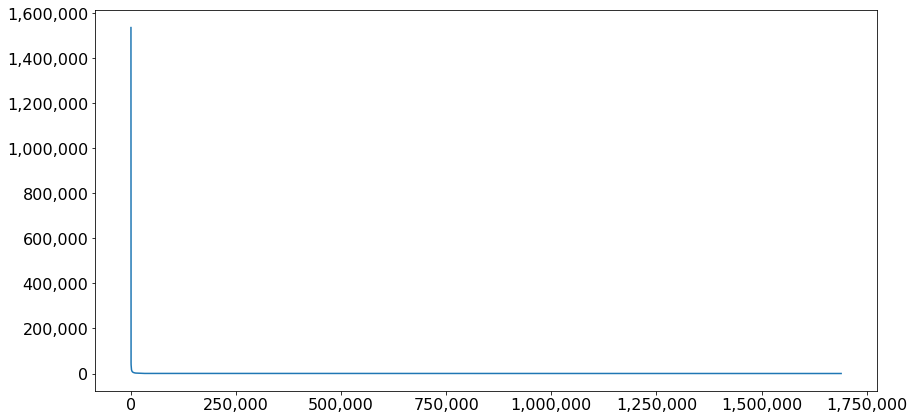

In [161]:
yr_eds = user_yr_revs.query("edits >= 1")
plt.plot(yr_eds["rank"], yr_eds["edits"])
plt.gca().xaxis.set_major_formatter(comma_fmt)
plt.gca().yaxis.set_major_formatter(comma_fmt);

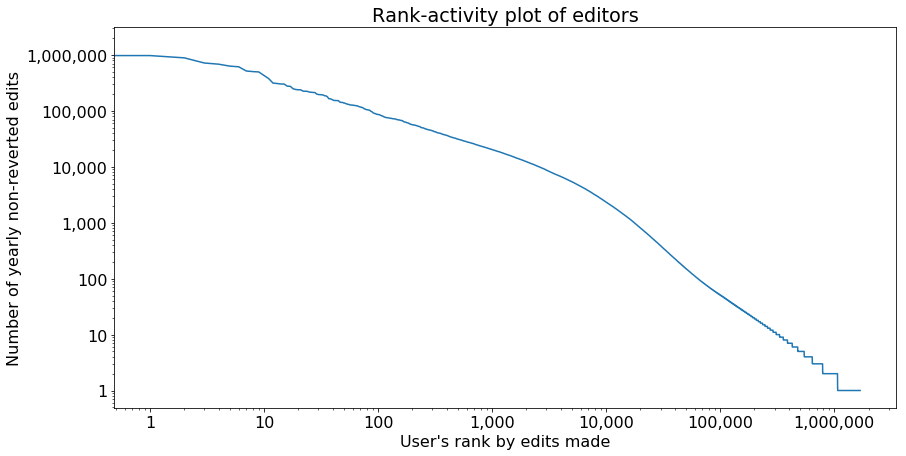

In [184]:
yr_eds = user_yr_revs.query("edits >= 1")
plt.plot(yr_eds["rank"], yr_eds["edits"])
plt.title("Rank-activity plot of editors")
ax = plt.gca()
plt.xlabel("User's rank by edits made")
ax.set_xscale("log")
ax.xaxis.set_major_formatter(comma_fmt)
plt.ylabel("Number of yearly non-reverted edits")
ax.set_yscale("log")
ax.yaxis.set_major_formatter(comma_fmt);

In [181]:
top_10_pct_rank = yr_eds.query("cum_prop >= 0.1")["rank"].min()
bottom_10_pct_rank = yr_eds.query("cum_prop >= 0.9")["rank"].min()

In [182]:
print(top_10_pct_rank, bottom_10_pct_rank)

40 38276


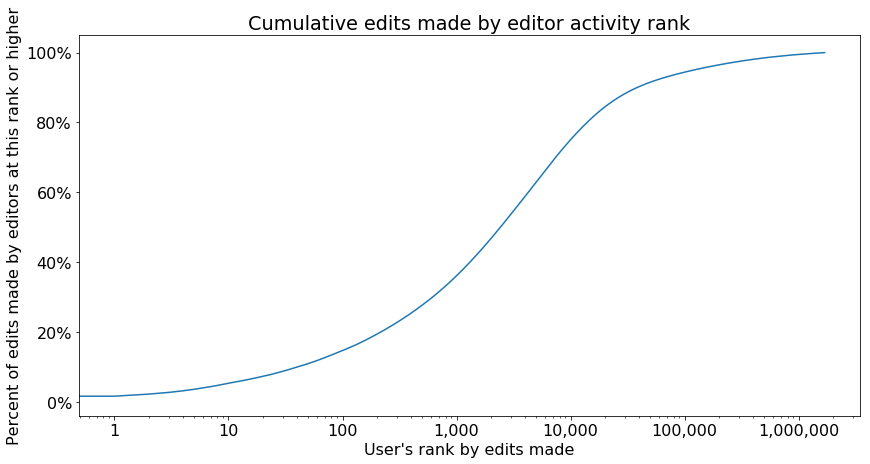

In [183]:
plt.plot(yr_eds["rank"], yr_eds["cum_prop"])
ax = plt.gca()
plt.title("Cumulative non-revedits made by editor activity rank")
ax.set_xscale("log")
plt.xlabel("User's rank by edits made")
ax.xaxis.set_major_formatter(comma_fmt)
plt.ylabel("Percent of edits made by editors at this rank or higher")
ax.yaxis.set_major_formatter(pct_fmt);

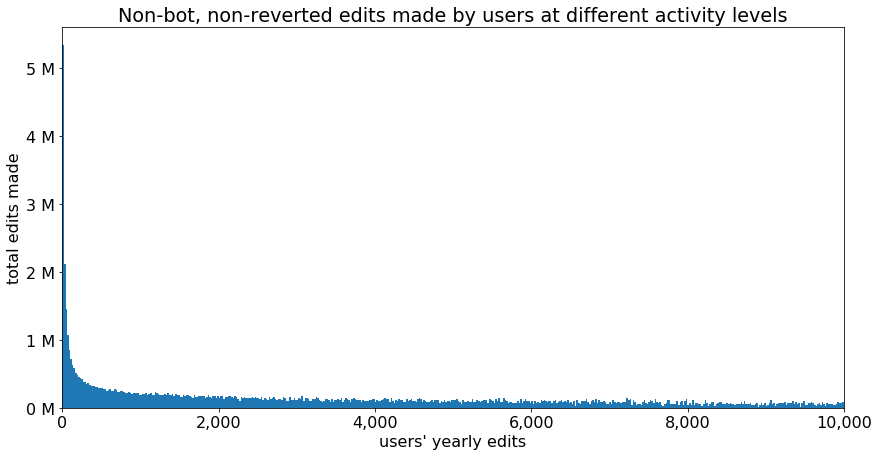

In [115]:
edits = user_yr_revs.query("edits < 10000")["edits"]

plt.hist(edits, weights=edits, bins=500)
plt.gca().yaxis.set_major_formatter(M_fmt)
plt.gca().xaxis.set_major_formatter(comma_fmt)
plt.title("Non-bot, non-reverted edits made by users at different activity levels")
plt.xlabel("users' yearly edits")
plt.ylabel("total edits made")
plt.autoscale(enable=True, axis="x", tight=True);

In [66]:
END = "2018-05-01"
SNAPSHOT = "2018-04"

user_mo_revs = wmf.hive.run("""
    select
        event_user_text as user,
        year(event_timestamp) as year,
        month(event_timestamp) as month,
        sum(if(wiki_db = "wikidatawiki", 0.1, 1)) as edits
    from wmf.mediawiki_history
    where
        -- NON-BOT
        event_user_is_bot_by_name = false and
        not array_contains(event_user_groups, "bot") and

        -- NON-REVERTED
        revision_is_identity_reverted = false and
        
        -- EDITS
        event_entity = "revision" and
        event_type = "create" and

        -- FROM THE LAST YEAR
        event_timestamp < "{end}" and
        event_timestamp >= date_sub("{end}", 365) and

        -- FROM THE LATEST SNAPSHOT
        snapshot = "{snapshot}"    
    -- PER USER
    group by event_user_text, year(event_timestamp), month(event_timestamp)
""".format(
    end = END, 
    snapshot = SNAPSHOT
))

user_mo_revs.head()

,user,year,month,edits
0,$wgUser,2017,10,2.0
1,--CharlestheCartoonist--,2017,10,1.0
2,--XenaDance--,2017,7,4.0
3,-xoxEmilia-,2017,8,21.0
4,.Raven,2018,2,12.0


In [68]:
user_mo_revs = user_mo_revs.query("user.notnull()")

In [74]:
yearly = user_mo_revs.groupby("user").agg({
    "month": "count",
    "edits": "sum"
})

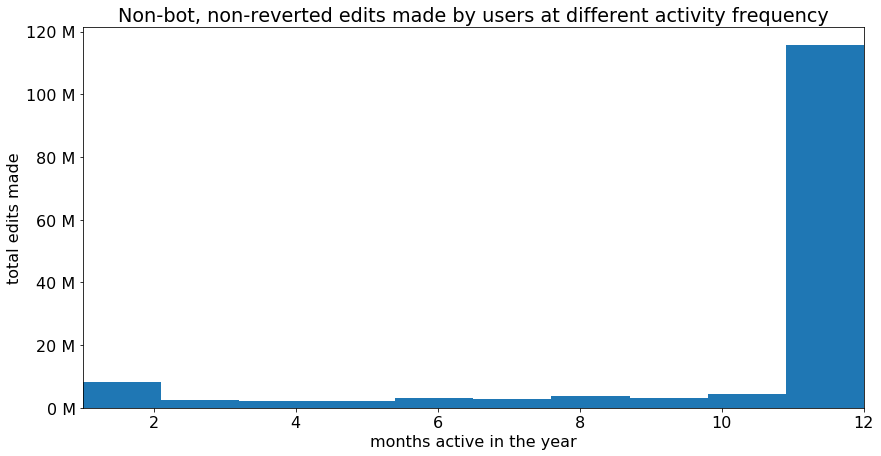

In [79]:
plt.hist(yearly["month"], weights=yearly["edits"])
plt.gca().yaxis.set_major_formatter(M_fmt)
plt.title("Non-bot, non-reverted edits made by users at different activity levels")
plt.xlabel("months active in the year")
plt.ylabel("total edits made")
plt.autoscale(enable=True, axis="x", tight=True);